# 가우시안 혼합모형과 EM 방법

## 가우시안 혼합모형

$K$-클래스 카테고리 확률변수 $Z$가 있다고 하자. 확률분포함수는 다음과 같다.

$$ p(z=k) = \pi_k $$

실수값을 출력하는 확률변수 $X$는 확률변수 $Z$의 표본값 $k$에 따라 기댓값 $\mu_k$, 분산 $\Sigma_k$이 달라진다.

$$ p(x \mid z) = \mathcal{N}(x\mid \mu_k, \Sigma_k) $$

이를 결합하면

$$ p(x) = \sum_Z p(z)p(x\mid z) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x \mid \mu_k, \Sigma_k) $$

이 된다.

실수값을 출력하는 확률변수 $X$가 $K$-클래스 카테고리 확률변수 $Z$의 값에 따라 다른 기댓값과 분산을 가지는 복수의 가우시안 정규분포들로 이루어진 모형을 가우시안 혼합(Gaussian Mixture) 모형이라고 한다.

단 가우시안 혼합모형에서 카테고리 확률변수 $Z$의 값을 알 수가 없다. 즉 관측되지 않는다고 가정한다. 이렇게 관측 데이터가 보이지 않는, 즉 내부에 숨겨진(latent) 확률 변수를 포함하는 모형을 잠재변수모형(latent variable model)이라고 한다. 잠재변수는 혼합모형처럼 카테고리값이 될 수도 있고 다른 모형에서는 실수값도 될 수 있다.

### 베르누이-가우시안 혼합모형

카테고리가 두 개인 가우시안 혼합모형은 베르누이-가우시안 혼합모형(Bernouilli Gaussian-Mixuture Model)이라고 한다.

<img src="https://datascienceschool.net/upfiles/74585dc917004bab9fa6c0fa058f8367.png" style="width: 100%">

그림 52.1 : 베르누이-가우시안 혼합모형의 예

다음은 2개의 카테고리와 2차원 가우시안 정규분포를 가지는 가우시안 혼합모형 데이터의 예이다.

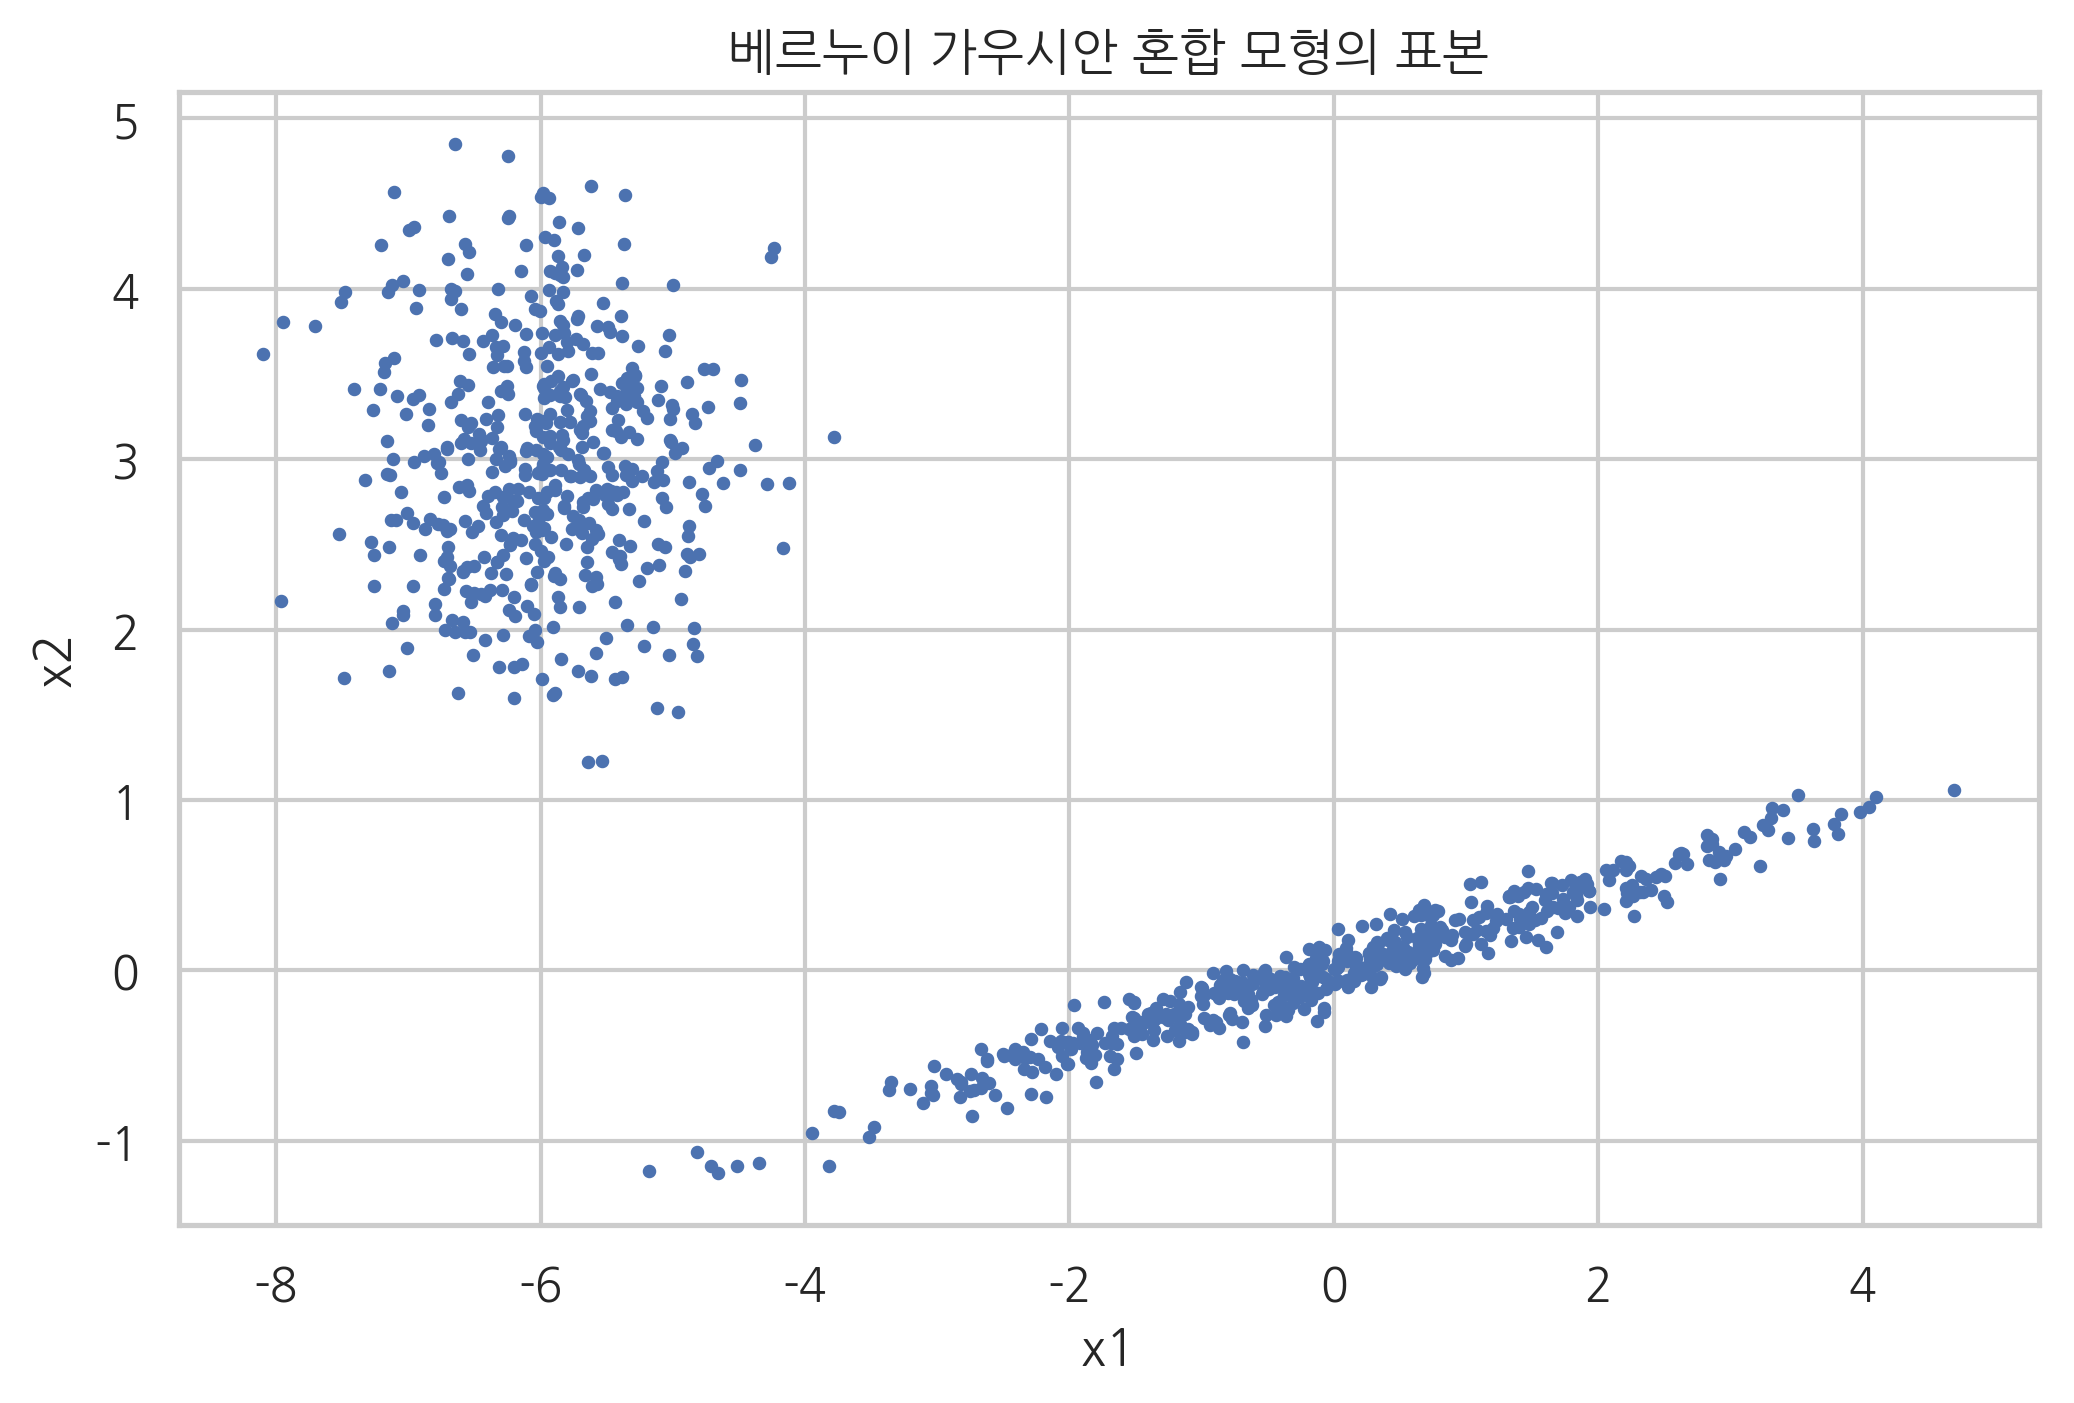

In [1]:
from numpy.random import randn

n_samples = 500

mu1 = np.array([0, 0])
mu2 = np.array([-6, 3])
sigma1 = np.array([[0., -0.1], [1.7, .4]])
sigma2 = np.eye(2)

np.random.seed(0)
X = np.r_[1.0 * np.dot(randn(n_samples, 2), sigma1) + mu1,
          0.7 * np.dot(randn(n_samples, 2), sigma2) + mu2]
plt.scatter(X[:, 0], X[:, 1], s=5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("베르누이 가우시안 혼합 모형의 표본")
plt.show()

## 가우시안 혼합모형의 모수 추정

데이터로부터 가우시안 혼합모형의 모수를 추정한다는 것은 관측되지 않는 카테고리 분포의 확률분포와 각각의 카테고리에서의 가우시안 정규분포 모수를 모두 추정하는 것을 말한다. 이 때 어려운 점은 확률분포함수가 선형대수 방법으로 쉽게 구할 수 없는 복잡한 형태를 가진다는 점이다. 

$N$개의 데이터에 대한 $X$의 확률분포는 

$$ p(x) = \prod_{i=1}^N p(x_i) = \prod_{i=1}^N \sum_{z_i} p(x_i,z_i) = \prod_{i=1}^N \sum_{z_i} p(z_i)p(x_i\mid z_i)  = \prod_{i=1}^N \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i\mid \mu_k, \Sigma_k) $$

이고 로그를 취하면

$$  \log p(x) = \sum_{i=1}^N \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i\mid \mu_k, \Sigma_k) \right) $$

이다. 두 식 모두 미분값이 0이 되는 모수값을 쉽게 구할 수 없다.

만약 데이터 $x_i$가 어떤 카테고리 $z_i$에 속하는지를 안다면 같은 카테고리에 속하는 데이터만 모아서 카테고리 확률분포 $\pi_k$도 알 수 있고 가우시안 정규분포의 모수 $\mu_k, \Sigma_k$도 쉽게 구할 수 있을 것이다. 하지만 실제로는 데이터 $x_i$가 가지고 있는 카테고리 값 $z_i$를 알 수가 없기 때문에 위  확률분포함수 $p(x)$를 최대화하는 $\pi_k$와 $\mu_k, \Sigma_k$를 비선형 최적화를 통해 구해야 한다.

네트워크 확률모형 관점에서는 확률변수 $Z_i$가 확률변수 $X_i$에 영향을 미치는 단순한 모형이다. 다만 $i=1,\dots,N$인 모든 경우에 대해 반복적으로 영행을 미치므로 이를 다음과 같은 판넬 모형으로 표현한다.

<img src="https://datascienceschool.net/upfiles/5dcd933716a3481eb6afb7945d18b05c.png" width="100%">

그림 52.2 : 판넬 모형

## EM(Expectation-Maximization)

혼합모형의 모수추정에서 중요한 역할을 하는 것 중의 하나가 바로 각 데이터가 어떤 카테고리에 속하는가를 알려주는 조건부 확률 $p(z\mid x)$ 값이다. 이 값을 responsibility라고 한다.

$$ 
\begin{eqnarray}
\pi_{ik} 
&=& p(z_i=k\mid x_i) \\
&=& \dfrac{p(z_i=k)p(x_i\mid z_i=k)}{p(x_i)} \\
&=& \dfrac{p(z_i=k)p(x_i\mid z_i=k)}{\sum_{k=1}^K p(x_i,z_i=k)} \\
&=& \dfrac{p(z_i=k)p(x_i\mid z_i=k)}{\sum_{k=1}^K p(z_i=k)p(x_i\mid z_i=k)} 
\end{eqnarray}
$$

가우시안 혼합모형의 경우 다음과 같이 정리할 수 있다. 

$$ 
\pi_{ik} = \dfrac{\pi_k \mathcal{N}(x_i\mid \mu_k, \Sigma_k)}{\sum_{k=1}^K \pi_k \mathcal{N}(x_i\mid \mu_k, \Sigma_k)} 
$$


이 식은 모수로부터 responsibility를 추정한다.

$$ (\pi_k, \mu_k, \Sigma_k) \;\; \implies \;\; \pi_{ik} $$


$\pi_{ik}$는 $i$번째 데이터 $x_i$가 카테고리 $k$에서 만들어졌을 확률을 나타낸다.

이제 로그-결합확률분포함수를 최대화한다.

우선 $\mu_k$로 미분하여 0이 되도록 하는 방정식을 만들면 다음과 같다.

$$ 0 = - \sum_{i=1}^N \dfrac{p(z_i=k)p(x_i\mid z_i=k)}{\sum_{k=1}^K p(z_i=k)p(x_i\mid z_i=k)} \Sigma_k (x_i - \mu_k ) $$

이를 정리하면,

$$ \sum_{i=1}^N \pi_{ik} (x_i - \mu_k ) = 0$$

$$ \mu_k = \dfrac{1}{N_k} \sum_{i=1}^N \pi_{ik} x_i $$

위 식에서 
$$ N_k = \sum_{i=1}^N \pi_{ik} $$

이고 $k$ 카테고리에 속하는 데이터의 수와 비슷한 의미를 가진다. 즉 $\mu_k$는 $k$카테고리에 속하는 데이터의 샘플 평균과 같의 의미이다.

마찬가지로 로그-결합확률분포함수를 $\Sigma_k$로 미분하여 최대화하는 모수값을 구하면 다음과 같다.

$$ \Sigma_k = \dfrac{1}{N_k} \sum_{i=1}^N \pi_{ik} (x_i-\mu_k)(x_i-\mu_k)^T $$


마지막으로 로그-결합확률분포함수를 $\pi_k$로 미분하여 최대화하는 모수값을 구해야 하는데 이 때 카테고리값의 모수가 가지는 제한 조건으로 인해 Lagrange multiplier 를 추가해야 한다.

$$ \log p(x) + \lambda \left(\sum_{k=1}^K \pi_k - 1 \right) $$


이를 $\pi_k$로 미분하여 0이 되는 값을 찾으면 다음과 같다.

$$ \pi_k = \dfrac{N_k}{N} $$


이 세가지 식은 모두 responsibility로부터 모수를 구하고 있다.

$$ \pi_{ik} \;\; \implies \;\; (\pi_k, \mu_k, \Sigma_k ) $$


원래는 연립방정식의 해를 구하는 방법으로 responsibility를 포함한 모수값을 추정해야 한다. 그러나 만약 식의 형태가 responsibility를 알고 있다면 모수를 추정하는 것이 간단하도록 만들어져 있기 때문에 EM(Expectation-Maximization)이라고 하는 iterative 방법을 사용하면 연립방정식의 해를 구하는 것보다 더 쉽게 모수를 추정할 수 있다.

EM 방법은 모수와 responsiblity를 번갈아 추정하며 정확도를 높여가는 방법이다.

* E step 에서는 우리가 현재까지 알고 있는 모수가 정확하다고 가정하고 이를 사용하여 각 데이터가 어느 카테고리에 속하는지 즉, responsiblity를 추정한다.

$$ (\pi_k, \mu_k, \Sigma_k) \;\; \implies \;\; \pi_{ik} $$

* M step 에서는 우리가 현재까지 알고 있는 responsibility가 정확하다고 가정하고 이를 사용하여 모수값을 추정한다.

$$ \pi_{ik} \;\; \implies \;\; (\pi_k, \mu_k, \Sigma_k)  $$

이를 반복하면 모수와 responsibility를 동시에 점진적으로 개선할 수 있다.

## 클러스터링


각각의 데이터에 대해 responsibility을 알게되면 responsibility가 가장 큰 카테고리를 찾아내어 그 데이터가 어떤 카테고리에 속하는지를 알 수 있다. 즉 클러스터링을 할 수 있다.

$$ k_i = \arg\max_{k} \pi_{ik} $$

사실 K-means clustering은 EM 방법의 특수한 경우라고 볼 수 있다.

## Scikit-Learn의 GaussianMixture 클래스

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

def plot_gaussianmixture(n):
    model = GaussianMixture(n_components=2, init_params='random', random_state=0, tol=1e-9, max_iter=n)
    with ignore_warnings(category=ConvergenceWarning):
        model.fit(X)
    pi = model.predict_proba(X)
    plt.scatter(X[:, 0], X[:, 1], s=50, linewidth=1, edgecolors="b", cmap=plt.cm.binary, c=pi[:, 0])
    plt.title("iteration: {}".format(n))

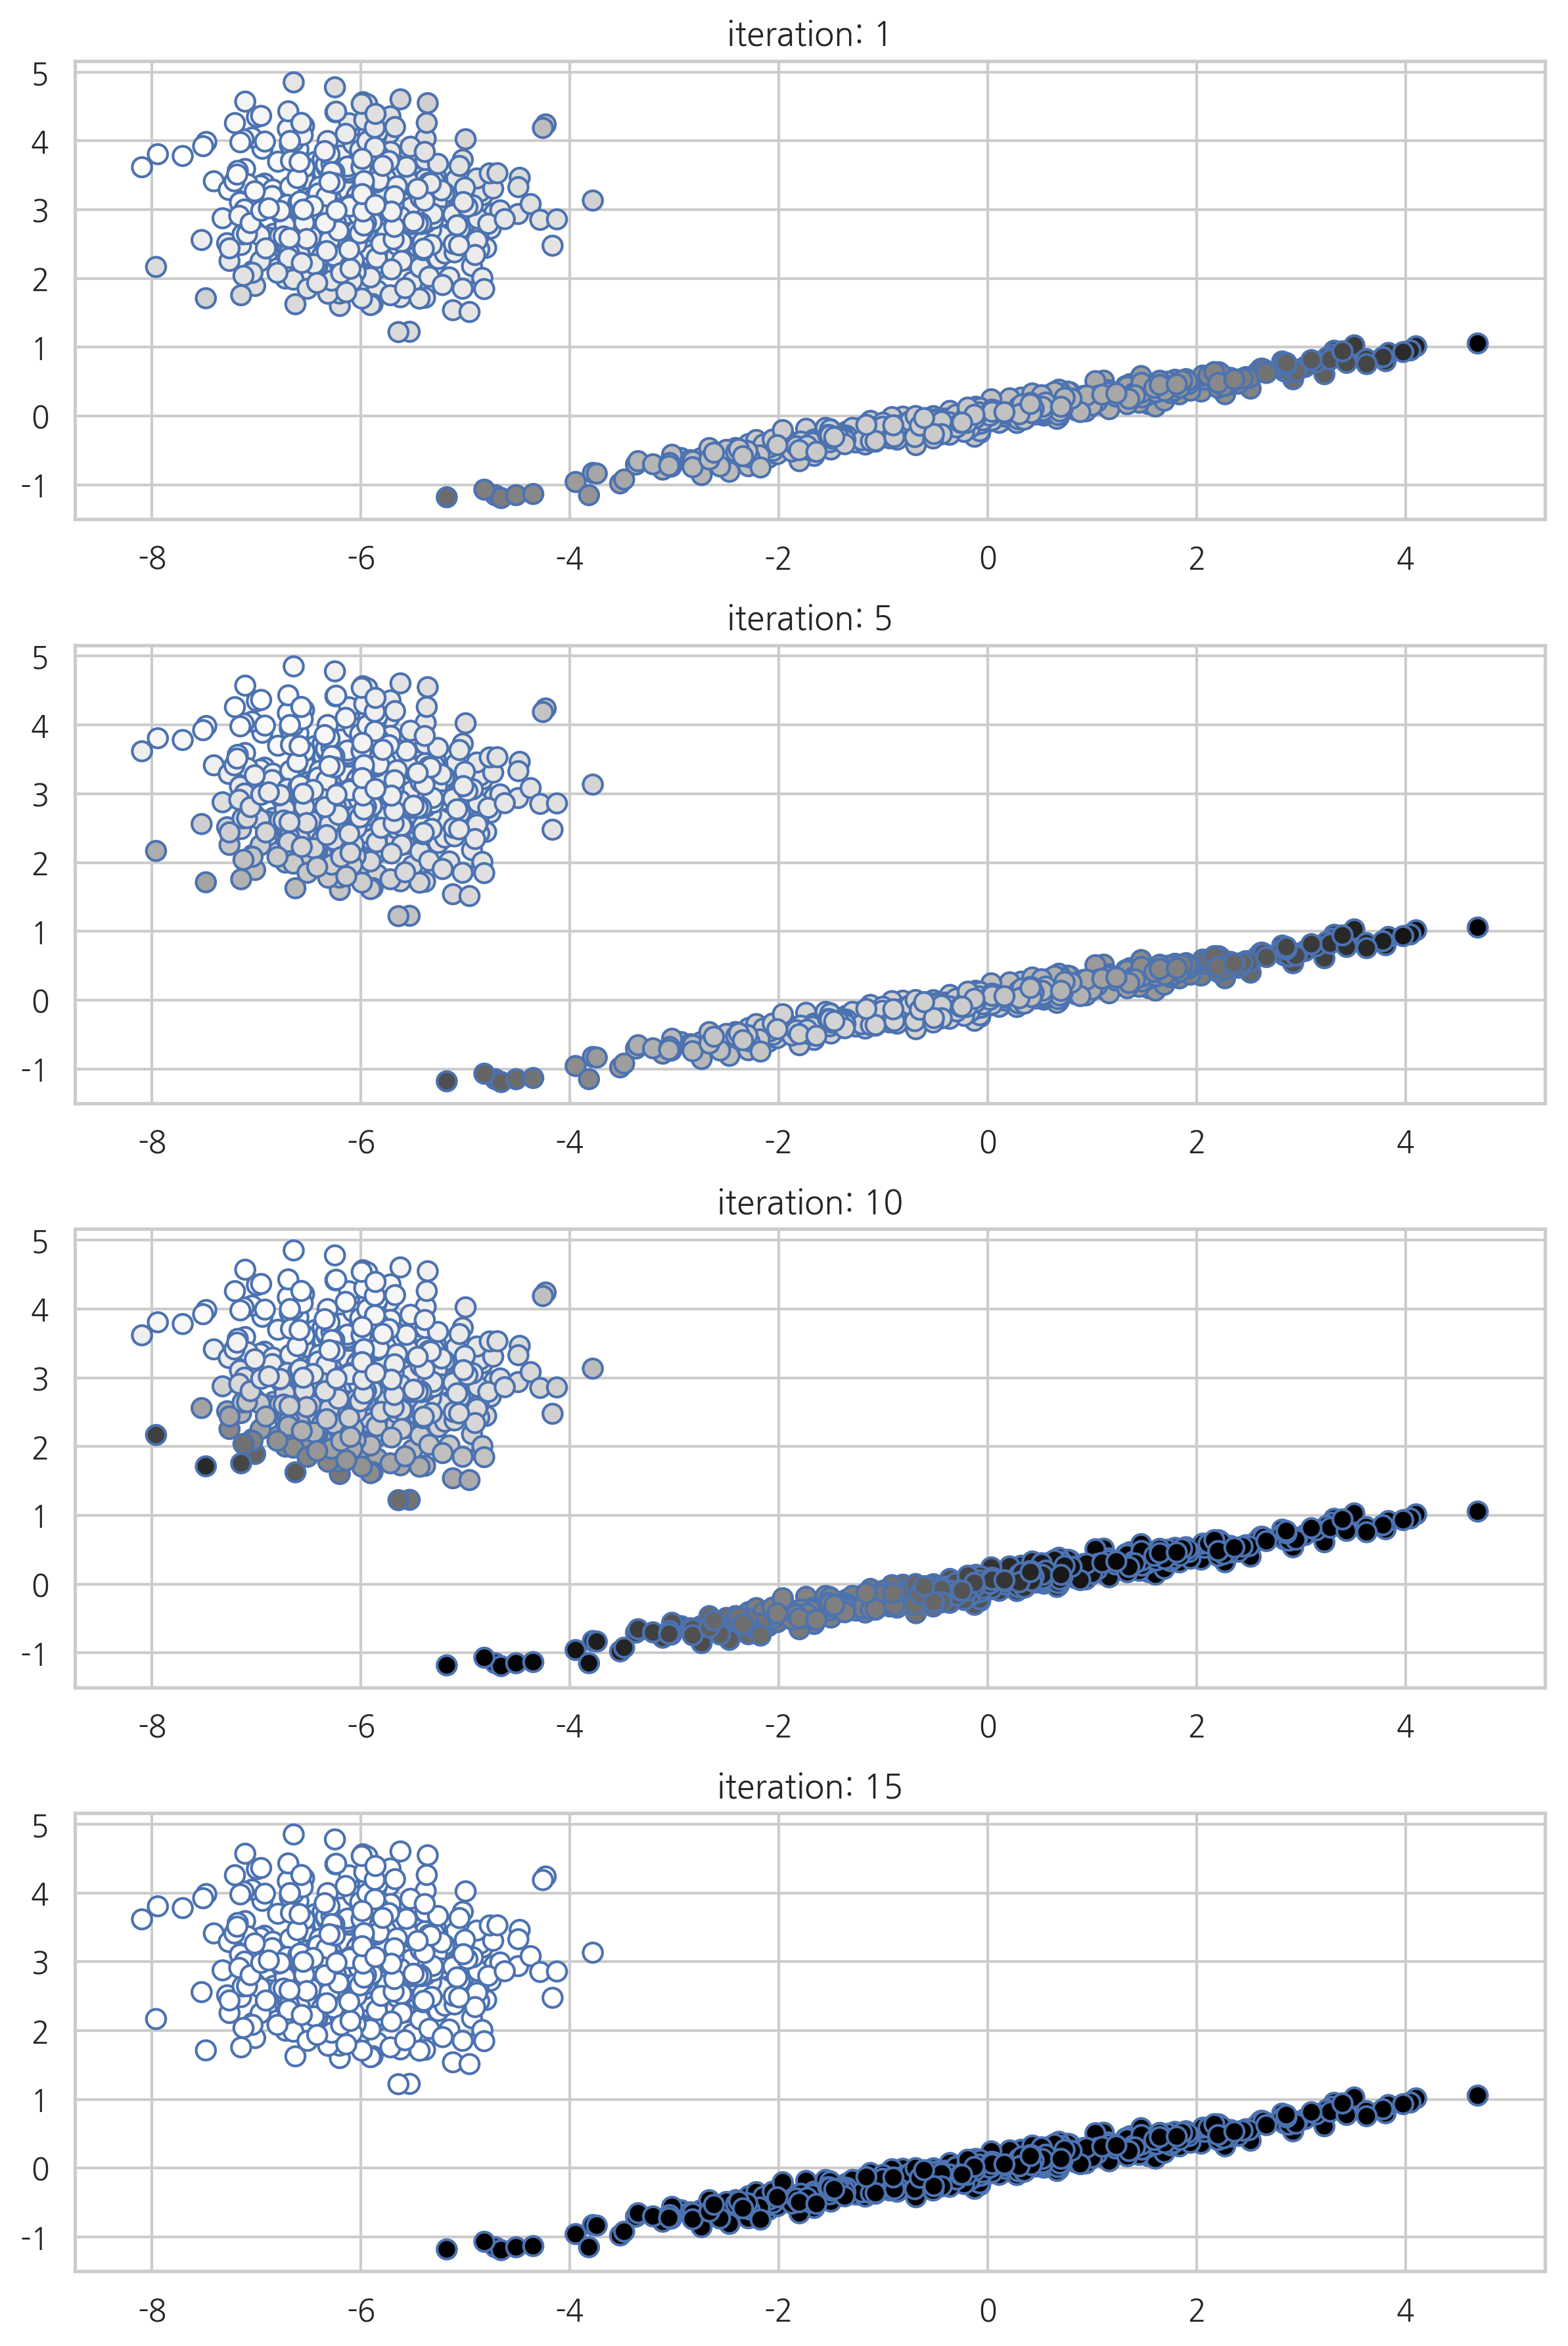

In [3]:
plt.figure(figsize=(8, 12))
plt.subplot(411)
plot_gaussianmixture(1)
plt.subplot(412)
plot_gaussianmixture(5)
plt.subplot(413)
plot_gaussianmixture(10)
plt.subplot(414)
plot_gaussianmixture(15)
plt.tight_layout()
plt.show()

## 일반적 EM 알고리즘

EM 알고리즘은 잠재변수 $z$에 의존하는 확률변수 $x$가 있고 $z$는 관측 불가능하며 $x$만 관측할 수 있는 경우 확률분포 $p(x)$를 추정하는 방법이다. 
다만 네트워크 모형에 의해 조건부확률분포 $p(x\mid z, \theta)$는 모수 $\theta$에 의해 결정되며 그 수식은 알고 있다고 가정한다.

혼합모형의 경우에는 $z$가 이산확률변수이므로 

$$ p(x \mid  \theta) = \sum_z p(x, z \mid  \theta) = \sum_z q(z) p(x\mid z, \theta) $$

가 성립한다.

주어진 데이터 $x$에 대해  가능도 $p(x \mid  \theta)$를 가장 크게 하는 잠재변수에 대한 확률분포 $q(z)$와 $\theta$를 구하는 것이 EM 알고리즘의 목표이다.

우선 다음 수식을 증명하자.

$$
\log p(x) = 
\sum_z q(z) \log \left(\dfrac{p(x, z \mid  \theta)}{q(z)}\right) -
\sum_z q(z) \log \left(\dfrac{p(z\mid x,  \theta)}{q(z)}\right)
$$

(증명)

$$
\begin{eqnarray}
\sum_z q(z) \log \left(\dfrac{p(x, z \mid  \theta)}{q(z)}\right)
&=& \sum_z q(z) \log \left(\dfrac{p(z \mid  x, \theta)p(x \mid  \theta)}{q(z)}\right) \\
&=& \sum_z \left( q(z) \log \left(\dfrac{p(z \mid  x, \theta)}{q(z)}\right) + q(z) \log p(x \mid  \theta) \right) \\
&=& \sum_z  q(z) \log \left(\dfrac{p(z \mid  x, \theta)}{q(z)}\right) + \sum_z q(z) \log p(x \mid  \theta)  \\
&=& \sum_z  q(z) \log \left(\dfrac{p(z \mid  x, \theta)}{q(z)}\right) + \log p(x \mid  \theta)  \\
\end{eqnarray}
$$

이제부터 이 식의 첫 항은 $L(q, \theta)$, 두번째 항은 $KL(q \mid  p)$라고 쓰도록 한다.

$$
L(q, \theta) = 
\sum_z q(z) \log \left(\dfrac{P(x, z \mid  \theta)}{q(z)}\right)
$$

$$
KL(q \mid  p) = 
-\sum_z q(z) \log \left(\dfrac{p(z\mid x,  \theta)}{q(z)}\right)
$$

$$
\log p(x) = L(q, \theta) + KL(q \mid  p)
$$

$L(q, \theta)$는 분포함수 $q(z)$를 입력하면 수치가 출력되는 범함수(functional)이다. $KL(q \mid  p)$은 분포함수 $q(z)$와 $p(z\mid x, \theta)$의 차이를 나타내는 쿨백-라이블러 발산이다. 쿨백-라이블러 발산은 항상 0과 같거나 크기 때문에 $L(q, \theta)$는 $\log p(x)$의 하한(lower bound)가 된다. 그래서 $L$을 ELBO(evidence lower bound)라고도 한다.

$$ \log p(x) \geq L(q, \theta) $$

반대로 이야기하면 $\log p(x)$가 $L(q, \theta)$의 상한이라고 할 수도 있다.

$L(q, \theta)$를 최대화하면 $\log p(x)$도 최대화된다. EM 알고리즘은 $L(q, \theta)$를 최대화하기위해 $q$와 $\theta$의 최적값을 교대로 찾아낸다. 


(1) E 단계에서는 $\theta$를 현재의 값 $\theta_{\text{old}}$으로 고정시키고 $L(q_\text{old}, \theta_\text{old})$를 최대화하는 $q_{\text{new}}$를 찾는다.
  
맞게 찾았다면 $L(q_{\text{new}}, \theta_\text{old})$는 상한인 $\log p(x)$와 같아진다. 즉 쿨백-라이블러 발산은 0이된다.
   
$$  L(q_{\text{new}}, \theta_\text{old}) = \log p(x) $$

$$ KL(q_{\text{new}} \mid  p) = 0 $$

$$ q_{\text{new}} = p(z\mid x, \theta_{\text{old}}) $$


(2) M 단계에서는 $q$를 현재의 함수 $q_{\text{new}}$로 고정시키고 $L(q_{\text{new}}, \theta)$를 최대화하는 $\theta_{\text{new}}$값을 찾는다.

최대화를 하였으므로 당연히 $L(q_{\text{new}}, \theta_{\text{new}})$는 옛날 값보다 커진다. 

$$ L(q_{\text{new}}, \theta_{\text{new}}) > L(q_{\text{new}}, \theta_{\text{old}}) $$

그리고 동시에 $p(Z\mid X, \theta_{\text{new}})$이 과거의 값 $p(Z\mid X, \theta_{\text{old}})$과 달라졌으므로 $q_{\text{new}}$는 $p(Z\mid X, \theta_{\text{new}})$와 달라진다.
그러면 쿨백 라이블러 발산의 값도 0보다 커지게 된다.

$$ q_{\text{new}} \neq p(Z\mid X, \theta_{\text{new}}) $$

$$ KL(q_{\text{new}} \mid  p) > 0 $$